<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/iCaRL-v1_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from copy import copy
from copy import deepcopy

#### Cloning the Git repository

In [2]:
!rm -rf ProjectMLDL
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 933, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 933 (delta 132), reused 61 (delta 61), pack-reused 757
Receiving objects: 100% (933/933), 23.49 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (485/485), done.
/content/ProjectMLDL


In [3]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.lwf import LearningWithoutForgetting

In [4]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.backends import cudnn
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from math import floor
from copy import copy, deepcopy
from model.lwf import LearningWithoutForgetting
from data.exemplar import Exemplar

class iCaRL(LearningWithoutForgetting):
  
  def __init__(self, device, net, LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, train_dl, validation_dl, test_dl, BATCH_SIZE, train_set, train_transform, test_transform):
    super().__init__(device, net, LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, train_dl, validation_dl, test_dl)
   
    self.BATCH_SIZE = BATCH_SIZE

    self.train_set = train_set
    # self.validation_set = validation_set
    # self.test_set = test_set
    
    self.train_transform = train_transform
    self.test_transform = test_transform
    self.memory_size = 2000
    self.exemplar_set = []
    self.means = None
  
  def train_model(self, num_epochs, herding: bool, classify: bool):
    
    cudnn.benchmark
    
    logs = {'group_train_loss': [float for j in range(10)],
             'group_train_accuracies': [float for j in range(10)],
             'predictions': [int],
             'test_accuracies': [float for j in range(10)],
             'true_labels': [int],
             'val_accuracies': [float for j in range(10)],
             'val_losses': [float for j in range(10)]}
    
    for g in range(10):
      self.net.to(self.DEVICE)
      
      self.parameters_to_optimize = self.net.parameters()
      self.optimizer = optim.SGD(self.parameters_to_optimize, lr=self.START_LR, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)
      self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=self.MILESTONES, gamma=self.GAMMA)
      
      best_acc = 0
      self.best_net = deepcopy(self.net)
      
      # augment train_set with exemplars and define DataLoaders for the current group
      self.update_representation(g, self.train_set[g])

      for epoch in range(num_epochs):
        e_loss, e_acc = self.train_epoch(g)
        e_print = epoch + 1
        print(f"Epoch {e_print}/{num_epochs} LR: {self.scheduler.get_last_lr()}")
        
        validate_loss, validate_acc = self.validate(g)
        g_print = g + 1
        print(f"Validation accuracy on group {g_print}/10: {validate_acc:.2f}")
        self.scheduler.step()
        
        if validate_acc > best_acc:
          best_acc = validate_acc
          self.best_net = deepcopy(self.net)
          best_epoch = epoch
          print("Best model updated")
        print("")
        
      print(f"Group {g_print} Finished!")
      be_print = best_epoch + 1
      print(f"Best accuracy found at epoch {be_print}: {best_acc:.2f}")
      
      m = self.reduce_exemplar_set()
      self.construct_exemplar_set(self.train_set[g], m, herding)
      
      if classify is True:
        test_accuracy, true_targets, predictions = self.test_classify(g, self.train_set[g])
      else:
        test_accuracy, true_targets, predictions = self.test(g)
      print(f"Testing classes seen so far, accuracy: {test_accuracy:.2f}")
      print("")
      print("=============================================")
      print("")
      logs['group_train_loss'][g] = e_loss
      logs['group_train_accuracies'][g] = e_acc
      logs['val_losses'][g] = validate_loss
      logs['val_accuracies'][g] = validate_acc
      logs['test_accuracies'][g] = test_accuracy

      if g < 9:
        self.add_output_nodes()
        self.old_net = deepcopy(self.best_net)

    logs['true_labels'] = true_targets
    logs['predictions'] = predictions
    return logs

########################################################################################################################
  
  def test_classify(self, classes_group_idx, train_set):
    self.best_net.train(False)
    running_corrects = 0
    total = 0

    all_preds = torch.tensor([])
    all_preds = all_preds.type(torch.LongTensor)
    all_targets = torch.tensor([])
    all_targets = all_targets.type(torch.LongTensor)
    
    self.means = None
    train_set.transform_status = False
    
    for _, images, labels in self.test_dl[classes_group_idx]:
      images = images.to(self.DEVICE)
      labels = labels.to(self.DEVICE)
      total += labels.size(0)

      with torch.no_grad():
        preds = self.classify(images, train_set)
      
      running_corrects += torch.sum(preds == labels.data).data.item()

      all_targets = torch.cat((all_targets.to(self.DEVICE), labels.to(self.DEVICE)), dim=0)
      all_preds = torch.cat((all_preds.to(self.DEVICE), preds.to(self.DEVICE)), dim=0)

    else:
      train_set.transform_status = True
      accuracy = running_corrects / float(total)  

    return accuracy, all_targets, all_preds
  
  def update_representation(self, classes_group_idx, train_set):
    print(f"Length of exemplars set: {sum([len(self.exemplar_set[i]) for i in range(len(self.exemplar_set))])}")
    exemplars = Exemplar(self.exemplar_set, self.train_transform)
    ex_train_set = ConcatDataset([exemplars, train_set])
    
    tmp_dl = DataLoader(ex_train_set,
                        batch_size=self.BATCH_SIZE,
                        shuffle=True, 
                        num_workers=4,
                        drop_last=True)
    self.train_dl[classes_group_idx] = copy(tmp_dl)
    print(len(self.train_dl[classes_group_idx]))
    
    #tmp_dl = DataLoader(validation_set,
    #                    batch_size=self.BATCH_SIZE,
    #                    shuffle=True, 
    #                    num_workers=4,
    #                    drop_last=True)
    #self.validation_dl[classes_group_idx] = copy(tmp_dl)
    
  def reduce_exemplar_set(self):
    m = floor(self.memory_size / self.net.fc.out_features)      
    print(f"Target number of exemplars: {m}")

    # from the current exemplar set, keep only first m
    for i in range(len(self.exemplar_set)):
      current_exemplar_set = self.exemplar_set[i]
      self.exemplar_set[i] = current_exemplar_set[:m]
    
    return m
  
  def construct_exemplar_set(self, train_set, m, herding: bool):   
    train_set.transform_status = False    
    samples = [[] for i in range(10)]
    new_exemplar_set = [[] for i in range(10)]
    for _, images, labels in train_set:
      labels = labels % 10
      samples[labels].append(images)
    train_set.transform_status = True
    
    if herding is True:
      new_exemplar_set = self.prioritized_selection(samples, new_exemplar_set, m)
    else:
      new_exemplar_set = self.random_selection(samples, new_exemplar_set, m)
    
    self.exemplar_set.extend(new_exemplar_set)
      
  def prioritized_selection(self, samples, exemplars, m):
    for i in range(10):
      print(f"Randomly extracting exemplars from class {i} of current split... ", end="")
      exemplars[i] = random.sample(samples[i], m) # delete this and implement algorithm 4 from iCaRL paper
      print(f"Extracted {len(exemplars[i])} exemplars.")
    return exemplars
  
  def random_selection(self, samples, exemplars, m):
    for i in range(10):
      print(f"Randomly extracting exemplars from class {i} of current split... ", end="")
      exemplars[i] = random.sample(samples[i], m)
      print(f"Extracted {len(exemplars[i])} exemplars.")
    return exemplars

  def classify(self, images, train_set):
    feature_map = self.features_extractor(images)
    for i in range(feature_map.size(0)):
      feature_map[i] = feature_map[i] / feature_map[i].norm()
    feature_map = feature_map.to(self.DEVICE)

    if self.means is None:
      self.mean_of_exemplars(train_set)

    class_labels = []
    for i in range(feature_map.size(0)):
      nearest_prototype = torch.argmin(torch.norm(feature_map[i]-self.means, dim=1))
      class_labels.append(nearest_prototype)
    
    return torch.stack(class_labels)

  def features_extractor(self, images, batch=True, transform=None):
    assert not (batch is False and transform is None), "if a PIL image is passed to extract_features, a transform must be defined"
    if batch is False:
      images = transforms.functional.to_pil_image(images)
      images = transform(images)
      images = images.unsqueeze(0)
    images = images.to(self.DEVICE)
    features = self.best_net.features(images)
    if batch is False: 
      features = features[0]
    return features
  
  def mean_of_exemplars(self, train_set):
    print("Computing mean of exemplars... ", end="")
    self.means = []
    train_features = [[] for i in range(10)]
    for _, img, labels in train_set:
      f = self.features_extractor(img, False, self.test_transform)
      f = f / f.norm()
      train_features[labels % 10].append(f)

    num_classes = len(self.exemplar_set)
    for i in range(num_classes):
      if i >= (num_classes-10):
        f_list = train_features[i % 10]
      else:
        f_list = []

      for img in self.exemplar_set[i]:
        f = self.features_extractor(img, False, self.test_transform)
        f = f / f.norm()
        f_list.append(f)

      f_list = torch.stack(f_list)
      class_means = f_list.mean(dim=0)
      class_means = class_means/class_means.norm()

      self.means.append(class_means)

    self.means = torch.stack(self.means).to(self.DEVICE)
    print("done")

#### Downloading data from Cifar100

In [5]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

In [6]:
train_data = CIFAR100("dataset", train=True, transform=train_transform, download=True)
test_data = CIFAR100("dataset", train=False, transform=test_transform, download=True)

Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified


classe: 90


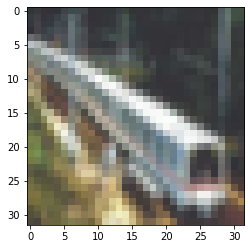

In [7]:
#check images and labels after shuffle
#https://github.com/keras-team/keras/issues/2653#issuecomment-450133996
import matplotlib.pyplot as plt

plt.imshow(train_data.data[6])
print("classe: {}".format(train_data.targets[6]))

## Incremental Classifier and Representation Learning

### Defining hyperparameters according to iCarl paper

In [18]:
# Settings
DEVICE = 'cuda'
NUM_CLASSES = 100         # Total number of classes
VAL_SIZE = 0.2            # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128          # Batch size
LR = 2                    # Initial learning rate
                       
MOMENTUM = 0.9            # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5       # Weight decay from iCaRL

RANDOM_SEED = [42]  # Random seeds defining the runs of every method
                          # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70           # Total number of training epochs
MILESTONES = [49, 63]     # Step down policy from iCaRL (MultiStepLR)
                          # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2               # Gamma factor from iCaRL (1/5)

HERDING = False           # True to perform prioritized selection, False to perform random selection
CLASSIFY = True           # True to use mean-of-exemplar classifier, False to use network's output directly for classification

### Definition of `do_shuffle` and `do_group_classes`
`do_shuffle` and `do_group_classes` are two functions that rispectively shuffle data downloaded from Cifar100 and get the incremental classes division for the incremental learning phase.



In [9]:
def do_shuffle(train_d, test_d):
  train_d.__shuffle_seed__(RANDOM_SEED[run])
  test_d.__shuffle_seed__(RANDOM_SEED[run])
  return train_d, test_d

def do_group_classes(train_d, test_d):
  indexes_train_data = train_d.__incremental_indexes__(True)
  indexes_test_data = test_d.__incremental_indexes__(False)


  train_s = [[] for i in range(10)]
  train_dataloader = [[] for i in range(10)]
  val_dataloader = [[] for i in range(10)]
  test_dataloader = [[] for i in range(10)]
  for i in range(10):
    train_dataset = Subset(train_d, indexes_train_data[i])
    train_set, val_set = torch.utils.data.random_split(train_dataset, 
                                                       [int((1-VAL_SIZE)*len(indexes_train_data[i])), int(VAL_SIZE*len(indexes_train_data[i]))])
    train_s[i] = copy(train_set)
    # tmp_dl = DataLoader(train_set, 
    #                     batch_size=BATCH_SIZE,
    #                     shuffle=True,
    #                     num_workers=4,
    #                     drop_last=True)
    # train_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi 
    tmp_dl = DataLoader(val_set, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    val_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi


    test_dataset = Subset(test_d, indexes_test_data[i])
    tmp_dl = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    test_dataloader[i] = copy(tmp_dl) # classi incrementali: 0:0-9, 1:0-19, 2:0-29, ..., 9:0-99
    
  return train_dataloader, val_dataloader, test_dataloader, train_s

### Going on with the model
This is the main iCaRL step.

This step is run 3 times with different `RANDOM_SEED`.
Here the model is instantiated, trained and tested.

Results and some statistics are then stored in the variable `logs`.

In [ ]:
logs = [[] for i in range(len(RANDOM_SEED))]
best_net_tot_classes = [None for i in range(len(RANDOM_SEED))]

for run in range(len(RANDOM_SEED)):
  random.seed(RANDOM_SEED[run])
  print("#################################")
  print(f"Radom seed: {RANDOM_SEED[run]}")
  print("")

  #shuffle data
  train_data, test_data = do_shuffle(train_data, test_data)
  #get dataloader separated in incremental groups of 10 classes
  train_dl, val_dl, test_dl, train_set = do_group_classes(train_data, test_data)

  #create the resnet
  net = resnet32()

  # #define criterion, parameters, optimizer and scheduler
  # criterion = nn.BCEWithLogitsLoss()
  # parameters_to_optimize = net.parameters()
  # optimizer = optim.SGD(parameters_to_optimize, 
  #                       lr=LR, 
  #                       momentum=MOMENTUM, 
  #                       weight_decay=WEIGHT_DECAY)
  # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
  #                                            milestones=MILESTONES, 
  #                                            gamma=GAMMA)
  
  
  trainer = iCaRL(DEVICE,
                  net,
                  LR,
                  MOMENTUM,
                  WEIGHT_DECAY,
                  MILESTONES,
                  GAMMA,
                  train_dl,
                  val_dl,
                  test_dl,
                  BATCH_SIZE,
                  train_set,
                  train_transform,
                  test_transform)

  #train and evaluate the model
  logs[run] = trainer.train_model(NUM_EPOCHS, HERDING, CLASSIFY)

  best_net_tot_classes[run] = deepcopy(trainer.best_net)

  print("#################################")
  print("")
  print("")

#################################
Radom seed: 42

Length of exemplars set: 0
31


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [2]
Validation accuracy on group 1/10: 0.12
Best model updated

Epoch 2/70 LR: [2]
Validation accuracy on group 1/10: 0.11

Epoch 3/70 LR: [2]
Validation accuracy on group 1/10: 0.09

Epoch 4/70 LR: [2]
Validation accuracy on group 1/10: 0.12
Best model updated

Epoch 5/70 LR: [2]
Validation accuracy on group 1/10: 0.10

Epoch 6/70 LR: [2]
Validation accuracy on group 1/10: 0.15
Best model updated

Epoch 7/70 LR: [2]
Validation accuracy on group 1/10: 0.17
Best model updated

Epoch 8/70 LR: [2]
Validation accuracy on group 1/10: 0.17
Best model updated

Epoch 9/70 LR: [2]
Validation accuracy on group 1/10: 0.19
Best model updated

Epoch 10/70 LR: [2]
Validation accuracy on group 1/10: 0.17

Epoch 11/70 LR: [2]
Validation accuracy on group 1/10: 0.17

Epoch 12/70 LR: [2]
Validation accuracy on group 1/10: 0.26
Best model updated

Epoch 13/70 LR: [2]
Validation accuracy on group 1/10: 0.22

Epoch 14/70 LR: [2]
Validation accuracy on group 1/10: 0.28
Best model updated

Epo

### Store logs in more usable dtype

In [ ]:
train_loss = [[logs[run_i]['group_train_loss'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
train_accuracy = [[logs[run_i]['group_train_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_loss = [[logs[run_i]['val_losses'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_accuracy = [[logs[run_i]['val_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
test_accuracy = [[logs[run_i]['test_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
predictions = [logs[run_i]['predictions'].cpu().data.numpy().tolist() for run_i in range(len(RANDOM_SEED))]
true_labels = [logs[run_i]['true_labels'].cpu().data.numpy().tolist() for run_i in range(len(RANDOM_SEED))]

### Save the model

#### Saving logs in JSON files

In [ ]:
import json

with open('states/LWF_train_loss.json', 'w') as f:
  json.dump(train_loss, f)
f.close
with open('states/LWF_train_accuracy.json', 'w') as f:
  json.dump(train_accuracy, f)
f.close
with open('states/LWF_val_loss.json', 'w') as f:
  json.dump(val_loss, f)
f.close  
with open('states/LWF_val_accuracy.json', 'w') as f:
  json.dump(val_accuracy, f)
f.close
with open('states/LWF_test_accuracy.json', 'w') as f:
  json.dump(test_accuracy, f)
f.close
with open('states/LWF_predictions.json', 'w') as f:
  json.dump(predictions, f)
f.close
with open('states/LWF_targets.json', 'w') as f:
  json.dump(true_labels, f)
f.close

#### Saving best resnet on 100 classes for each seed

In [12]:
for i in range(len(RANDOM_SEED)):
  torch.save(best_net_tot_classes[i].state_dict(), "states/LWF_bestnet_seed[{}]".format(RANDOM_SEED[i]))

### Print some graphs

In [ ]:
from data.utils_plot import plot_train_val, plot_test_accuracies, plot_confusion_matrix

In [ ]:
train_loss = np.array(train_loss)
train_accuracy = np.array(train_accuracy)
val_loss = np.array(val_loss)
val_accuracy = np.array(val_accuracy)
test_accuracy = np.array(test_accuracy)

train_loss_stats = np.array([train_loss.mean(0), train_loss.std(0)]).transpose()
train_accuracy_stats = np.array([train_accuracy.mean(0), train_accuracy.std(0)]).transpose()
val_loss_stats = np.array([val_loss.mean(0), val_loss.std(0)]).transpose()
val_accuracy_stats = np.array([val_accuracy.mean(0), val_accuracy.std(0)]).transpose()
test_accuracy_stats = np.array([test_accuracy.mean(0), test_accuracy.std(0)]).transpose()

#### Train validation loss

In [ ]:
plot_train_val(train_loss_stats, val_loss_stats, loss = True)

#### Train validation accuracy

In [ ]:
plot_train_val(train_accuracy_stats, val_accuracy_stats, loss = False)

#### Test accuracy

In [ ]:
plot_test_accuracies(test_accuracy_stats)

#### Confusion Matrix

In [ ]:
for run in range(len(RANDOM_SEED)):
  targets = np.array(true_labels[run])
  preds = np.array(predictions[run])

  plot_confusion_matrix(targets, preds, RANDOM_SEED[run], 'iCaRL')